In [1]:
from itertools import islice
import time

import matplotlib.pyplot as plt
import networkx as nx
from networkx.classes.function import path_weight
import numpy as np
from tqdm import tqdm
from scipy.optimize import curve_fit

from networkx.generators.harary_graph import hkn_harary_graph
import h5py

In [2]:
def path_to_bit_rep(p, G):
    p = [(v, p[i+1]) for i, v in enumerate(p[:-1])]
    
    bit_rep = []
    for e in G.edges():
        if (e[0], e[1]) in p:
            bit_rep.append(1)
        else:
            bit_rep.append(0)
    
    return np.array(bit_rep)


def compute_dH(p0, p1, G):
    p0 = path_to_bit_rep(p0, G)
    p1 = path_to_bit_rep(p1, G)
    
    return np.abs(p0 - p1).sum()


def sp(n, source, target):
    G = hkn_harary_graph(3, n)
    edges = G.edges()
    
    np.random.seed()
    W = np.random.rand(G.number_of_edges())

    G = nx.DiGraph(G)
    for i, e in enumerate(edges):
        G[e[0]][e[1]]['weight'] = W[i]
        G[e[1]][e[0]]['weight'] = W[i]

    p0, p1 = list(islice(nx.shortest_simple_paths(G, source, target, weight="weight"), 2))
    delta = path_weight(G, p1, weight="weight") - path_weight(G, p0, weight="weight")

    return delta

14


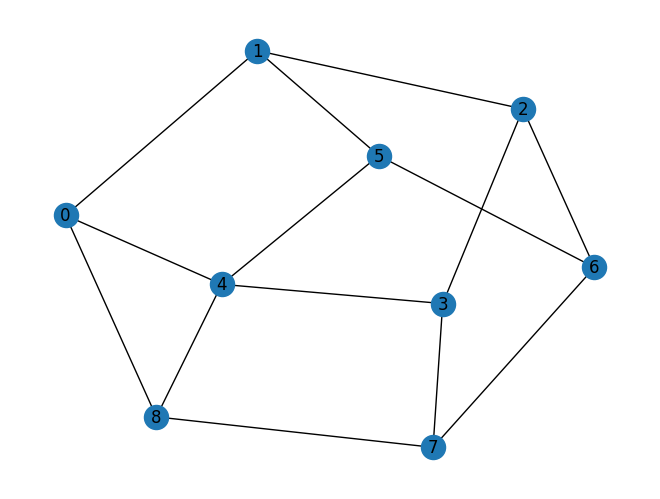

In [3]:
G = hkn_harary_graph(3, 9)
# G = nx.DiGraph(G)
print(G.number_of_edges())
nx.draw(G, with_labels=True)
# plt.savefig("harary.pdf")

In [4]:
to_compute = False
if to_compute:
    M = 10000

    df = np.zeros((n_max+1-4, 2))
    for n in range(4, 16):
        f = h5py.File(f"data/harary/adj/adj_n={n}.jld", "r")
        source = int(np.array(f["source"]))-1
        target = int(np.array(f["target"]))-1
        
        dfM = np.zeros(M)
        for m in tqdm(range(M)):
            dfM[m] = sp(n, source, target)
        df[n-4] = (dfM.mean(), dfM.std(ddof=1) / M**0.5)

    np.save("data/harary/deltaF.npy", df)
    
delta_f = np.load("data/harary/deltaF.npy")
df = np.load("data/harary/harary.npy")

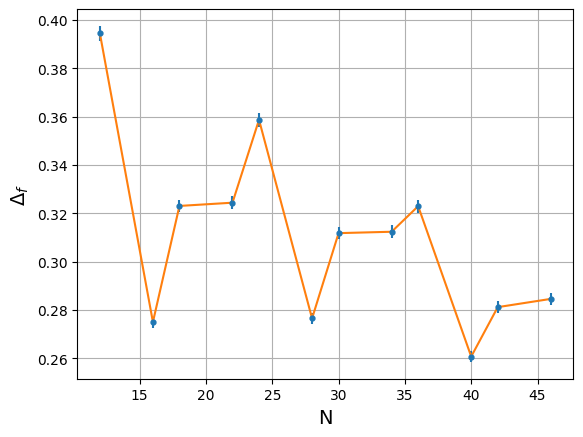

In [5]:
f_fit = lambda x, a, b, c: a / x**b + c

N = []
for i in range(4, 16):
    G = hkn_harary_graph(3, i)
    N.append(G.number_of_edges()*2)
x = np.linspace(N[0], max(N))

plt.errorbar(N, delta_f[:, 0], yerr=delta_f[:, 1], fmt=".", ms=7, label="$\Delta_f$")
plt.plot(N, delta_f[:, 0])

plt.xlabel("N", fontsize=14)
plt.ylabel("$\Delta_f$", fontsize=14)
plt.grid()

plt.savefig("plots/harary_deltaf.pdf")

[ 1.88069883e+01  9.62479097e-01 -3.21278238e-04]
[9.64687377e-01 8.30362577e-03 1.17366950e-04]


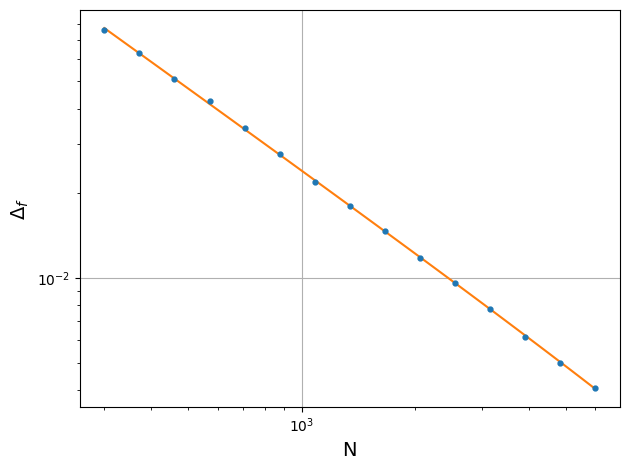

In [6]:
f_fit = lambda x, a, b, c: a / x**b + c

N = df[:, 0]
x = np.linspace(N[0], max(N))

plt.errorbar(N, df[:, 1], yerr=df[:, 2], fmt=".", ms=7, label="$\Delta_f$")
popt, pcov = curve_fit(f_fit, N, df[:, 1], sigma=df[:, 2], p0=[1, 1, 0], maxfev=10000,
                       bounds=([0, 0, -1], [np.inf, np.inf, np.inf]))

plt.plot(x, f_fit(x, *popt))
plt.xlabel("N", fontsize=14)
plt.ylabel("$\Delta_f$", fontsize=14)

plt.xscale("log")
plt.yscale("log")
plt.grid()

plt.tight_layout()
plt.savefig("plots/harary_df.pdf")

print(popt)
print(np.sqrt(np.diag(pcov)))

2499


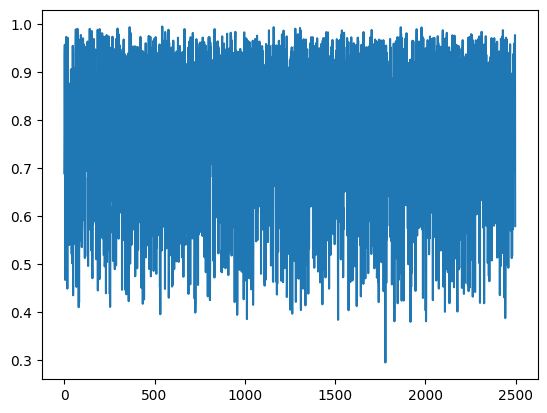

2482


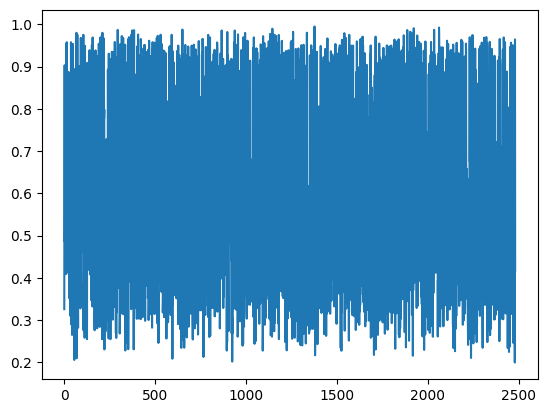

2253


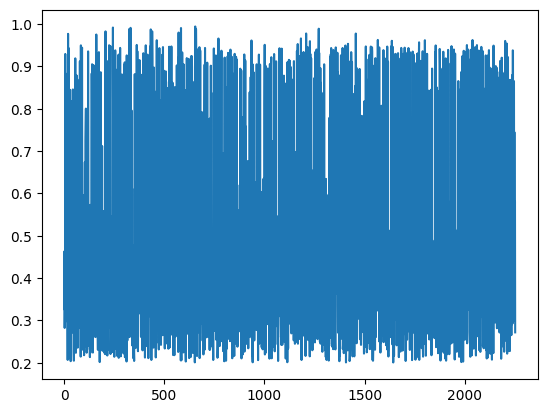

645


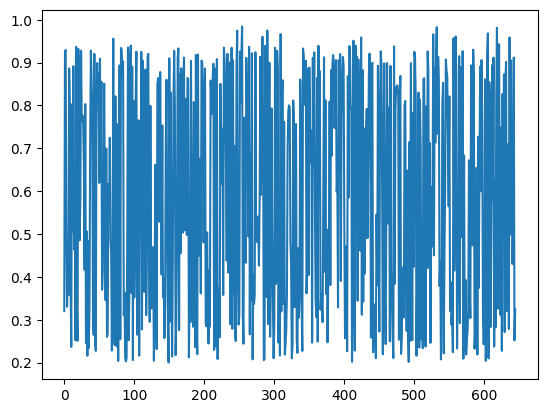

113


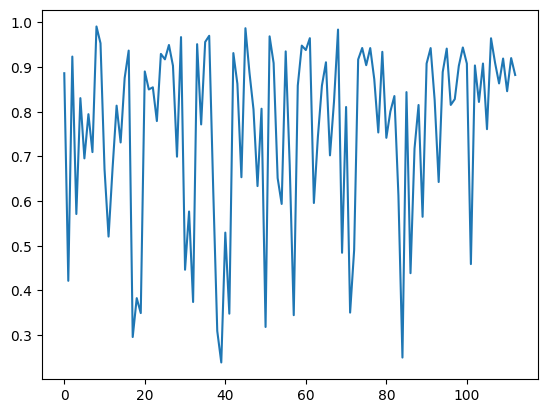

In [15]:
n_max = 8

sc = np.zeros((n_max+1-4, 2))
dmin = np.zeros((n_max+1-4, 2))
overlap = np.zeros((n_max+1-4, 2))

for n in range(4, n_max+1):
    f = h5py.File(f"data/harary/n={n}.jld", "r")
    scM, dminM = np.array(f["scM"]), np.array(f["dminM"])
    overlapM = np.array(f["overlapM"])

    scM = scM[(scM != 0) & (overlapM > 0.2)]
    dminM = dminM[(dminM != 0) & (overlapM > 0.2)]
    overlapM = overlapM[(overlapM != 0) & (overlapM > 0.2)]
    M = scM.shape[0]
    print(M)

    plt.plot(overlapM)
    plt.show()
    
    if M == 0:
        continue

    sc[n-4] = np.mean(scM), np.std(scM, ddof=1) / np.sqrt(M)
    dmin[n-4] = np.mean(dminM), np.std(dminM, ddof=1) / np.sqrt(M)
    overlap[n-4] = np.mean(overlapM), np.std(overlapM, ddof=1) / np.sqrt(M)

In [16]:
N = np.zeros(n_max+3-4)
for n in range(4, n_max+3):
    G = hkn_harary_graph(3, n)
    N[n-4] = G.number_of_edges()*2

delta_f = delta_f[:n_max+3-4, :]

B = 1
A = N.copy()

first_order = np.zeros(delta_f.shape)
first_order[:, 0] = 2 * B*delta_f[:, 0] / (B*delta_f[:, 0] + A+2)
first_order[:, 1] = 2*(A+2) / (B*delta_f[:, 0] + A+2)**2 * B*delta_f[:, 1]

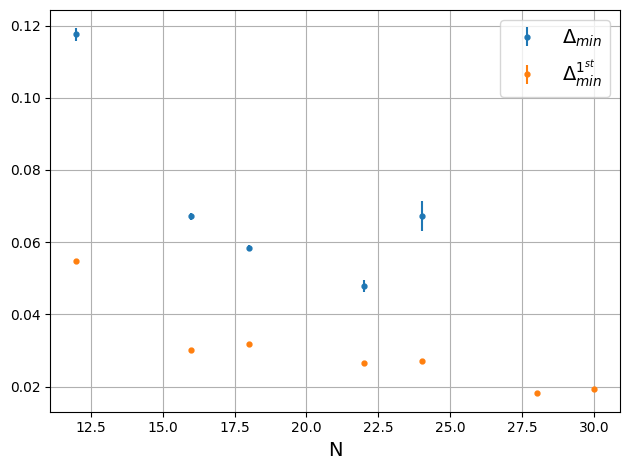

In [17]:
f_fit = lambda x, a, b, c, d: a / x**b + c / x**d

# plt.figure(figsize=(8, 6))
plt.errorbar(N[:n_max+1-4], dmin[:, 0], yerr=dmin[:, 1], fmt=".", ms=7, label="$\Delta_{min}$")
plt.errorbar(N, first_order[:, 0], yerr=first_order[:, 1], fmt=".", ms=7, label="$\Delta_{min}^{1^{st}}$")
# plt.errorbar(N, delta_f[:, 0] / delta_f[0, 0], yerr=delta_f[:, 1], fmt=".", ms=7, label="$\Delta_f$")

# x = np.linspace(N[0], N[-1], 1000)
# popt, pcov = curve_fit(f_fit, N[:5], dmin[:5, 0], sigma=dmin[:5, 1], 
#                        p0=[0.1, 0.1, 1, 1], bounds=([0, 1, 0, 0.1], [np.inf, np.inf, np.inf, np.inf]))
# plt.plot(x, f_fit(x, *popt))
# print(popt)

# x = np.linspace(N[0], N[-1], 1000)
# popt, pcov = curve_fit(f_fit, N, first_order[:, 0], sigma=first_order[:, 1], p0=[0.1, 1, 0.05, 0], maxfev=10000, 
#                        bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]))
# plt.plot(x, f_fit(x, *popt))
# print(popt)

plt.xlabel("N", fontsize=14)
plt.legend(prop={'size': 14})
plt.grid()
plt.tight_layout()
plt.savefig("plots/harary_dmin.pdf")

[9.33507510e+01 3.04193106e+00 1.47011263e-02]
[1.27227046e+02 5.79931549e-01 4.56429159e-03]


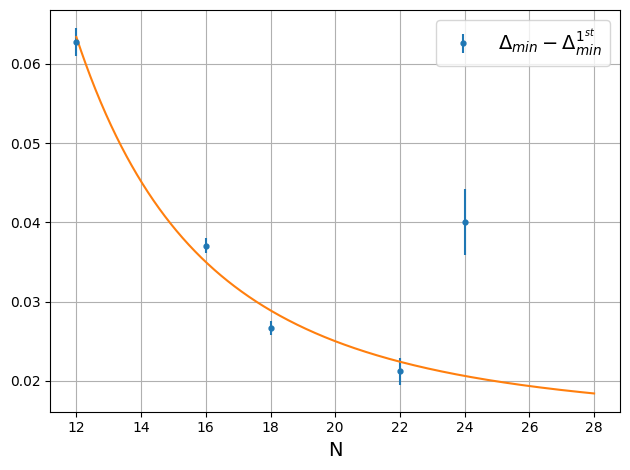

In [18]:
f_fit = lambda x, a, b, c: a / x**b + c

dd = dmin[:, 0] - first_order[:n_max+1-4, 0]
dd_err = np.sqrt(dmin[:, 1]**2 + first_order[:n_max+1-4, 1]**2)

plt.errorbar(N[:n_max+1-4], dd, yerr=dd_err, fmt=".", ms=7, label="$\Delta_{min} - \Delta_{min}^{1^{st}}$")

popt, pcov = curve_fit(f_fit, N[:n_max+1-4], dd, sigma=dd_err, p0=[0.3, 0.5, 2], absolute_sigma=True, maxfev=5000)
x = np.linspace(N[0], N[n_max+1-4], 1000)
plt.plot(x, f_fit(x, *popt))
print(popt)
print(np.sqrt(np.diag(pcov)))

plt.legend(prop={'size': 14})
plt.xlabel("N", fontsize=14)
plt.grid()

plt.tight_layout()
plt.savefig("plots/harary_ddmin.pdf")

1.7729308157750479 0.5211416349573007 1.5493835183965938e-15
2.2358493277156093 1.0271134559790904 3.2420543299365336
[1.01816717 0.11560247 3.73547306]


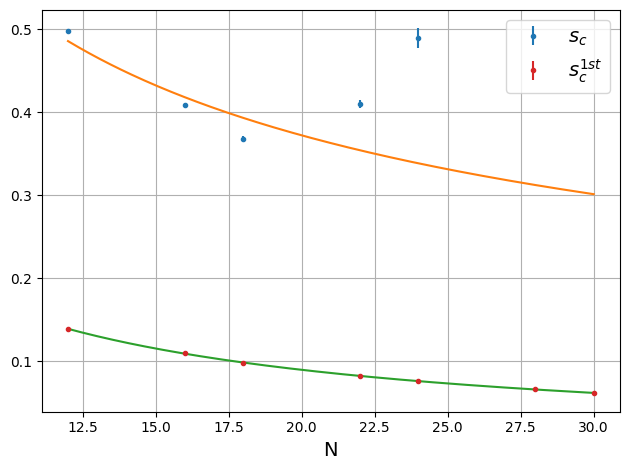

In [19]:
f_fit = lambda x, a, b, c: a / (x**b + c)

plt.errorbar(N[:n_max+1-4], sc[:, 0], fmt='.', yerr=sc[:, 1], label="$s_c$")
x = np.linspace(N[0], N[n_max+1-4+1], 200)
popt, pcov = curve_fit(f_fit, N[:n_max+1-4], sc[:, 0], sigma=sc[:, 1], 
                       p0=[0.1, 1, 0.1], bounds=[(0, 0, 0), (np.inf, np.inf, np.inf)])
print(*popt)
plt.plot(x, f_fit(x, *popt))

sc_first = first_order[:, 0] / delta_f[:, 0]
dsc_first = np.sqrt((first_order[:, 1]/first_order[:, 0])**2 + (delta_f[:, 1]/delta_f[:, 0])**2) * sc_first

popt, pcov = curve_fit(f_fit, N, sc_first, maxfev=10000,
                       sigma=dsc_first, p0=[1, 0.1, 0.1], absolute_sigma=True,
                       bounds=[(0, 0, 0), (np.inf, np.inf, np.inf)])
print(*popt)
print(np.sqrt(np.diag(pcov)))
plt.plot(x, f_fit(x, *popt))

plt.errorbar(N, sc_first, yerr=dsc_first, fmt='.', label="$s_c^{1st}$")

plt.legend(prop={'size': 14})
plt.xlabel("N", fontsize=14)
plt.grid()

plt.tight_layout()
plt.savefig("plots/2rows_sc.pdf")

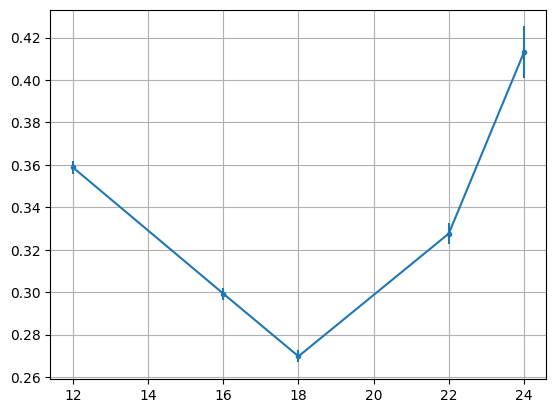

In [20]:
d_sc = sc[:, 0] - sc_first[:n_max+1-4]
dd_sc = np.sqrt(sc[:, 1]**2 + dsc_first[:n_max+1-4]**2)
plt.errorbar(N[:n_max+1-4], d_sc, yerr=dd_sc, fmt=".-", label="$s_c - s_c^{1^{st}}$")
plt.grid()

<ErrorbarContainer object of 3 artists>

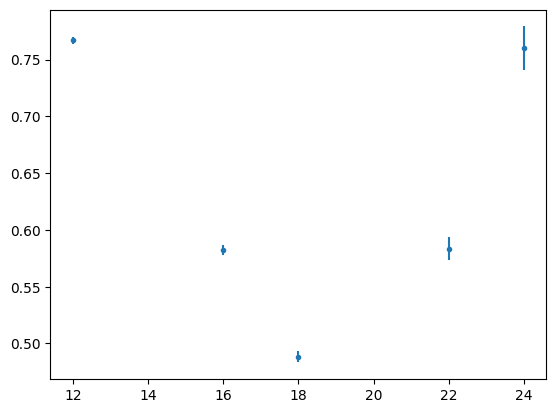

In [21]:
plt.errorbar(N[:n_max-4+1], overlap[:, 0], fmt='.', yerr=overlap[:, 1])

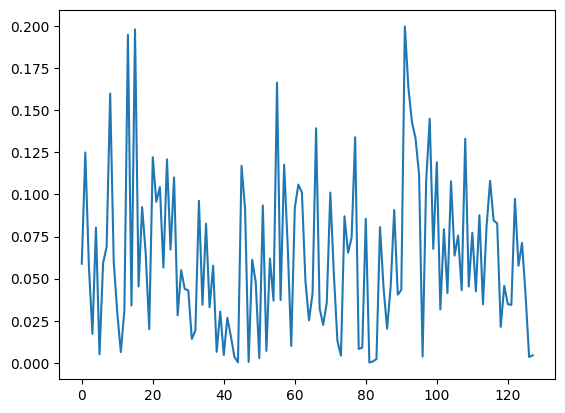

In [14]:
plt.plot(dminM)